### High Low Efficiency Analysis

读取数据中...
转换为 Pandas 中...
样本总数： 6000
[Top 10 最大资源利用率值]
      resource_efficiency  priority  scheduling_class  failed  run_duration
4321            38.362205     200.0               2.0       0   300000000.0
4187            28.879740     200.0               3.0       0   300000000.0
4348            26.867052     200.0               3.0       0   300000000.0
2974            26.782212     199.0               3.0       0   300000000.0
1155            17.471861     200.0               3.0       0   300000000.0
2132            15.151515     200.0               1.0       0   300000000.0
2541            12.849673     200.0               3.0       0   300000000.0
5424             9.784912     200.0               3.0       0   300000000.0
19               9.585139       0.0               0.0       0   300000000.0
184              8.247525     200.0               3.0       0   300000000.0

[Top 10 最低资源利用率任务]
      resource_efficiency  priority  scheduling_class  run_duration
4882             0.000

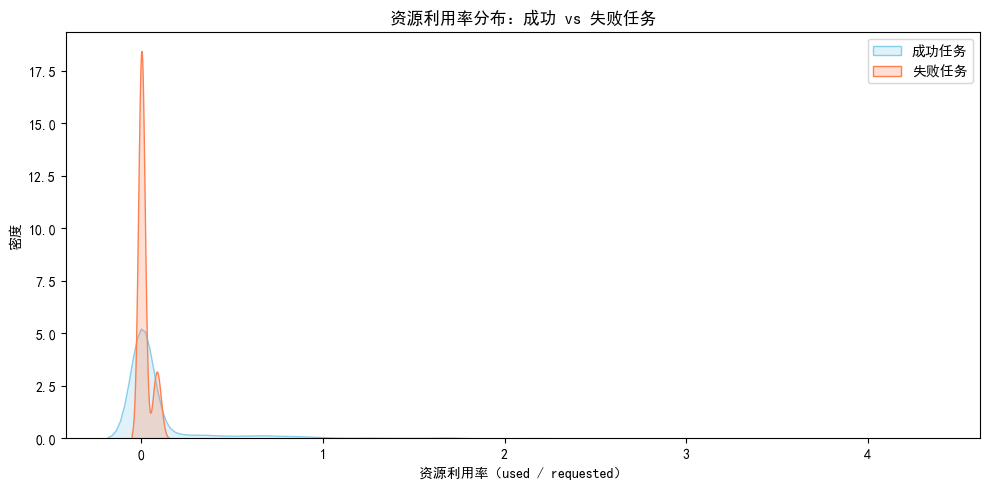

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# 初始化 Spark
spark = SparkSession.builder \
    .appName("EDA_ResourceEfficiency_Analysis") \
    .config("spark.executor.python.worker.timeout", "300") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "5000") \
    .getOrCreate()

# 读取数据
print("读取数据中...")
df_clean = spark.read.parquet("../data/cleaned_borg_data.parquet")

# 选择相关字段并转换为 Pandas
print("转换为 Pandas 中...")
df_eff = df_clean.select("resource_efficiency", "priority", "scheduling_class", "failed", "run_duration") \
    .filter((col("resource_efficiency").isNotNull()) & (col("failed").isNotNull())) \
    .sample(False, 0.05, seed=42).limit(6000).toPandas()

print("样本总数：", len(df_eff))

# 打印最大值分析信息
print("[Top 10 最大资源利用率值]")
print(df_eff.sort_values("resource_efficiency", ascending=False).head(10))

# ✅ Top-k Inefficient Tasks (lowest resource efficiency > 0)
top_k = 10
ineff_df = df_eff[df_eff["resource_efficiency"] > 0].copy()
ineff_df_sorted = ineff_df.sort_values(by="resource_efficiency", ascending=True).head(top_k)

# 显示表格
display_cols = ["resource_efficiency", "priority", "scheduling_class", "run_duration"]
df_display = ineff_df_sorted[display_cols].rename(columns={
    "resource_efficiency": "resource_efficiency",
    "priority": "priority",
    "scheduling_class": "scheduling_class",
    "failed": "failed",
    "run_duration": "run_duration"
})
print("\n[Top 10 最低资源利用率任务]")
print(df_display)

# ✅ 截断最大值（如 > 5 的值）
df_eff = df_eff[df_eff["resource_efficiency"] < 5]

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘图
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_eff[df_eff.failed == 0], x="resource_efficiency", fill=True, label="成功任务", color="skyblue")
sns.kdeplot(data=df_eff[df_eff.failed == 1], x="resource_efficiency", fill=True, label="失败任务", color="coral")
plt.title("资源利用率分布：成功 vs 失败任务")
plt.xlabel("资源利用率（used / requested）")
plt.ylabel("密度")
plt.legend()
plt.tight_layout()
plt.show()

# 停止 Spark
spark.stop()

### 低效率任务（如 resource_efficiency < 0.1）在 priority、run_duration、scheduling_class 等维度的分布

✅ Loading cleaned data...
✅ Filtering low-efficiency tasks...
✅ Sample size: 6000


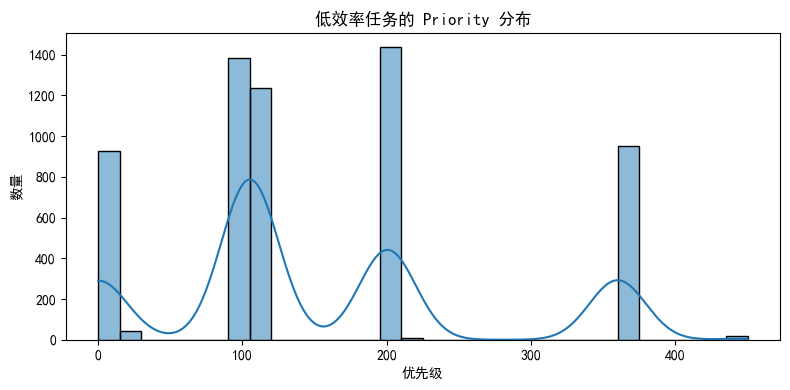

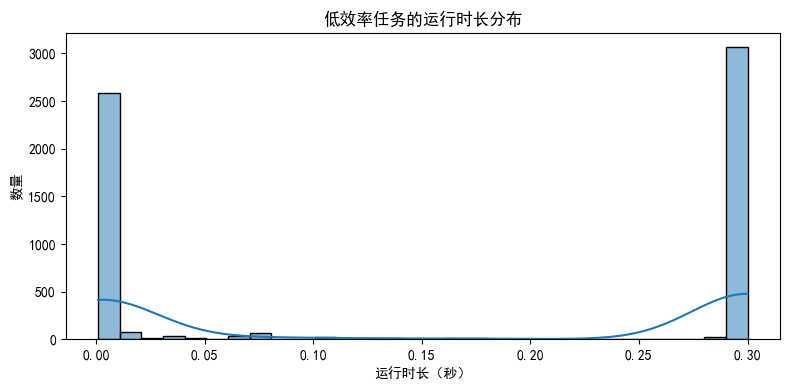

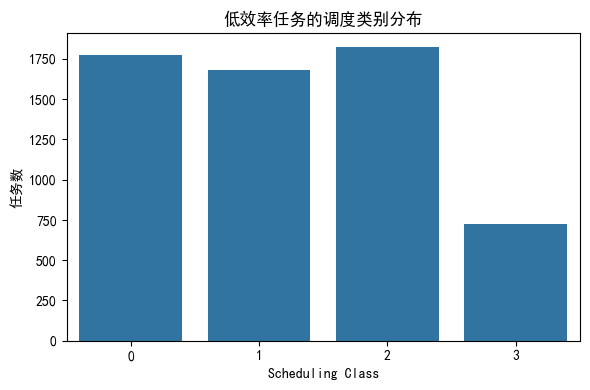

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Step 1: 初始化 Spark
spark = SparkSession.builder \
    .appName("LowEfficiency_Analysis") \
    .config("spark.executor.python.worker.timeout", "300") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Step 2: 读取数据
print("\u2705 Loading cleaned data...")
df = spark.read.parquet("../data/cleaned_borg_data.parquet")

# Step 3: 过滤有效记录
print("\u2705 Filtering low-efficiency tasks...")
df_low_eff = df.filter(
    (col("resource_efficiency") < 0.1) &
    col("priority").isNotNull() &
    col("run_duration").isNotNull() &
    col("scheduling_class").isNotNull()
).select("priority", "run_duration", "scheduling_class", "resource_efficiency")

# Step 4: 转为 Pandas（截断记录数）
df_pd = df_low_eff.limit(6000).toPandas()
print("\u2705 Sample size:", len(df_pd))

# Step 5: 可视化分析
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 优先级分布
plt.figure(figsize=(8, 4))
sns.histplot(df_pd["priority"], kde=True, bins=30)
plt.title("低效率任务的 Priority 分布")
plt.xlabel("优先级")
plt.ylabel("数量")
plt.tight_layout()
plt.show()

# 运行时长分布（单位：秒）
df_pd["run_seconds"] = df_pd["run_duration"] / 1e9
plt.figure(figsize=(8, 4))
sns.histplot(df_pd["run_seconds"], kde=True, bins=30)
plt.title("低效率任务的运行时长分布")
plt.xlabel("运行时长（秒）")
plt.ylabel("数量")
plt.tight_layout()
plt.show()

# 调度等级分布
plt.figure(figsize=(6, 4))
sns.countplot(x="scheduling_class", data=df_pd)
plt.title("低效率任务的调度类别分布")
plt.xlabel("Scheduling Class")
plt.ylabel("任务数")
plt.tight_layout()
plt.show()

spark.stop()